### Analysis and plotting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import os
import datetime as dt
import xarray as xr
from scipy import stats
import re
from scipy.signal import argrelextrema, argrelmax

import warnings
warnings.filterwarnings('ignore')

# Import functions for computing summary statistics
import resampled_stats as rs

# use this function to match the date/time of observations
def nearest(items, pivot):
    # https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date
    return min(items, key=lambda x: abs(x - pivot))

Set font sizes for plots

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

A summary stats function

In [3]:
a = np.array([10, 11, 12, np.nan])
b = np.array([0.03874, 0.289347, 0.00327384, 0.000327])

print(b[(np.isnan(a)==False) & (np.isnan(b)==False)])

[0.03874    0.289347   0.00327384]


In [4]:
def summary_stats(_a, _b):
    '''Compute summary statistics for the difference between two sets.
    Input two flattened (1-D) arrays with NaN values removed'''
    
    # remove nan values
    a = _a[(np.isnan(_a)==False) & (np.isnan(_b)==False)]
    b = _b[(np.isnan(_a)==False) & (np.isnan(_b)==False)]
    
    # for difference stats
    diff = b - a
    
    # for linear regression stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(a, b)
    
    # populate dict with summary stats
    summary_stats_dict = {
        #'diff' : diff ,
        'n' : len(diff) ,
        'mean_diff' : np.nanmean( diff ),
        'median_diff' : np.nanmedian( diff ),
        'mean_squared_diff' : np.nanmean( diff**2 ),
        'rms_diff' : np.sqrt( np.nanmean( diff**2 ) ),
        'std_diff' : np.nanstd( diff ),
        'slope' : slope,
        'intercept' : intercept,
        'r_value' : r_value,
        'p_value' : p_value,
        'std_err' : std_err
        }
    
    return summary_stats_dict

---

# Open datasets

CUES dataset which is the merged GOES-16 brightness temperature and CUES station data:

In [5]:
cues_ds = pd.read_pickle('data/goes-cues_2017-2020.pkl')
cues_ds = cues_ds.to_xarray().squeeze()

GOES-16 ABI Cloud Mask product:

In [6]:
goes_cloudmask = pd.read_pickle('data/GOES-16_ABI-L2-ACMC_CUES_2017-2020.pkl')
goes_cloudmask = goes_cloudmask.to_xarray()

### Compute diff

(GOES Tb - CUES Tss) and add it to the dataset

In [7]:
cues_ds['goes_cues_diff'] = cues_ds.goes_tb_c - cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']

### Filter entire dataset to only snow-on conditions, and cloud-free

Set thresholds for where we want to ignore snow surface temperature and GOES brightness temperature measurements. It looks like I can be safe by saying "no snow" is anywhere below 5 cm of snow depth. I'll use the daily median snow depth to check this.

And of course we want no cloud-cover, so only look at where cloud_flag=0.

In [8]:
snow_depth_treshold = 5 # cm

# My original idea was to use this carefully created "cloud flag",  it seems to under-predicts true cloud cover
filter_conditions = ((cues_ds.cloud_flag == 0) & (cues_ds.daily_median_snow_depth >= snow_depth_treshold))

# simple Clear Sky Index > 1 means we have clouds
#filter_conditions2 = ((cues_ds.lclr_mean > cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']) & (cues_ds.daily_median_snow_depth >= snow_depth_treshold))

# using the sun flag doesn't make much of a difference because the Clear Sky Index LW method i'm using here is biased towards saying we have clear skies
# when cloud_flag == 0 almost always sun_flag == 1
#filter_conditions3 = (((cues_ds.cloud_flag == 0) | (cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)'] == 1)) & (cues_ds.daily_median_snow_depth >= snow_depth_treshold))

# Apply the filter, call this "cues_snow"
cues_snow = cues_ds.where(filter_conditions)

Make a plot to preview some of this data showing snow melting away

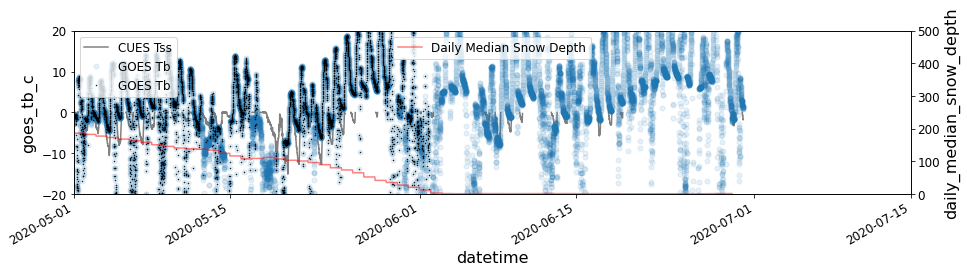

In [9]:
startdate = pd.Timestamp(2020,5,1)
enddate = pd.Timestamp(2020,7,15)

fig, ax = plt.subplots(1,1,figsize=(15,3))

cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].plot(linestyle='-', color='grey', ax=ax, label='CUES Tss')
cues_ds.goes_tb_c.plot(linestyle='none', marker='.', markersize=10, color='tab:blue', ax=ax, label='GOES Tb', alpha=0.1)
cues_snow.goes_tb_c.plot(linestyle='none', marker='.', markersize=1, color='k', ax=ax, label='GOES Tb')

ymax = 20
ymin = -20
ax.set_ylim([ymin,ymax])

# plot the cloud mask (this is a binary, 0 or 1), multiply by ymax on the temperature scale so that it spans the plot vertically
#ax.plot(goes_cloudmask.datetime, goes_cloudmask.BCM, color='grey', alpha=0.3, label='GOES-16 Cloud Mask', zorder=0)
#ax.plot(cues_snow.datetime, cues_ds.cloud_flag,alpha=0.3, label='CUES Cloud Flag')


ax2 = ax.twinx()
ax2.set_ylim([0,500])
cues_ds.daily_median_snow_depth.plot(color='red',label='Daily Median Snow Depth', ax=ax2, alpha=0.5)

ax.set_xlim([startdate,enddate])
ax.legend(loc='upper left')
ax2.legend(loc='upper center')

Make a plot showing the effect of trying to filter out cloud cover and only look at snow-on conditions:

{'n': 199053, 'mean_diff': -5.108612667747328, 'median_diff': 0.7441613769531252, 'mean_squared_diff': 224.9377180237462, 'rms_diff': 14.99792379043667, 'std_diff': 14.101056507747133, 'slope': 0.40159243598335764, 'intercept': -9.133482188132266, 'r_value': 0.1694393596496112, 'p_value': 0.0, 'std_err': 0.005235565140998692}
{'n': 116795, 'mean_diff': -0.5396637688567688, 'median_diff': 2.9516931152343746, 'mean_squared_diff': 126.32601938052183, 'rms_diff': 11.239484836082205, 'std_diff': 11.226521384520904, 'slope': 0.5653805981828802, 'intercept': -3.86805417246568, 'r_value': 0.3276311014494058, 'p_value': 0.0, 'std_err': 0.004770785483433674}


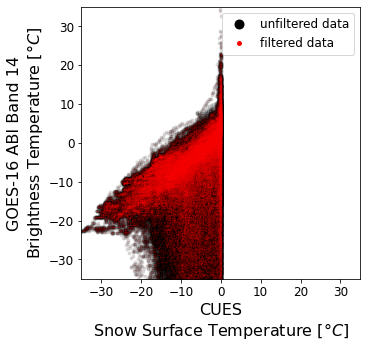

In [10]:
x1 = cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
y1 = cues_ds.goes_tb_c

print(summary_stats(x1, y1))

x2 = cues_snow['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
y2 = cues_snow.goes_tb_c

print(summary_stats(x2, y2))

plt.figure(figsize=(5,5))

plt.plot(x1, y1, '.k',alpha=0.1, label='unfiltered data')
plt.plot(x2, y2, '.r',alpha=0.1,markersize=1, label='filtered data')


legend_elements= [Line2D([0], [0], marker='o', color='none', label='unfiltered data',
                          markerfacecolor='k', markeredgecolor='none', markersize=10),
                  Line2D([0], [0], marker='o', color='none', label='filtered data',
                          markerfacecolor='r', markeredgecolor='none', markersize=5)]
plt.legend(handles=legend_elements, loc='upper right')

plt.xlim((-35,35))
plt.ylim((-35,35));

plt.xlabel('CUES\nSnow Surface Temperature [$\degree C$]')
plt.ylabel('GOES-16 ABI Band 14\nBrightness Temperature [$\degree C$]');

---

Make a plot showing the overal change due to orthorectifying the ABI imagery:

{'n': 116821, 'mean_diff': 0.09559570539875407, 'median_diff': 3.9277397016120177, 'mean_squared_diff': 139.12607277126804, 'rms_diff': 11.795171587190584, 'std_diff': 11.79478419609182, 'slope': 0.6368823740146731, 'intercept': -2.6852242052012354, 'r_value': 0.344538058531851, 'p_value': 0.0, 'std_err': 0.005077215245586323}
{'n': 116795, 'mean_diff': -0.5396637688567688, 'median_diff': 2.9516931152343746, 'mean_squared_diff': 126.32601938052183, 'rms_diff': 11.239484836082205, 'std_diff': 11.226521384520904, 'slope': 0.5653805981828802, 'intercept': -3.86805417246568, 'r_value': 0.3276311014494058, 'p_value': 0.0, 'std_err': 0.004770785483433674}


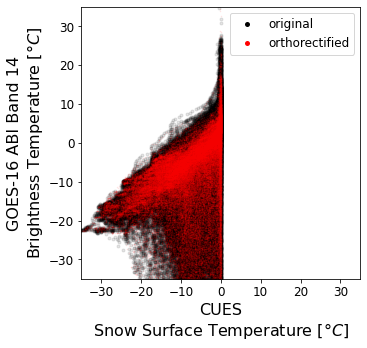

In [11]:
x1 = cues_snow['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
y1 = cues_snow.goes_tb_not_orthorectified_c

print(summary_stats(x1, y1))

x2 = cues_snow['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
y2 = cues_snow.goes_tb_c

print(summary_stats(x2, y2))

plt.figure(figsize=(5,5))

plt.plot(x1, y1, '.k',alpha=0.1, label='unfiltered data')
plt.plot(x2, y2, '.r',alpha=0.1,markersize=1, label='filtered data')


legend_elements= [Line2D([0], [0], marker='o', color='none', label='original',
                          markerfacecolor='k', markeredgecolor='none', markersize=5),
                  Line2D([0], [0], marker='o', color='none', label='orthorectified',
                          markerfacecolor='r', markeredgecolor='none', markersize=5)]
plt.legend(handles=legend_elements, loc='upper right')

plt.xlim((-35,35))
plt.ylim((-35,35));

plt.xlabel('CUES\nSnow Surface Temperature [$\degree C$]')
plt.ylabel('GOES-16 ABI Band 14\nBrightness Temperature [$\degree C$]');

---

# Boxplots and Histograms

Resample, compute summary stats

In [63]:
SMALL_SIZE = 10
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

For context, snow depth @ CUES

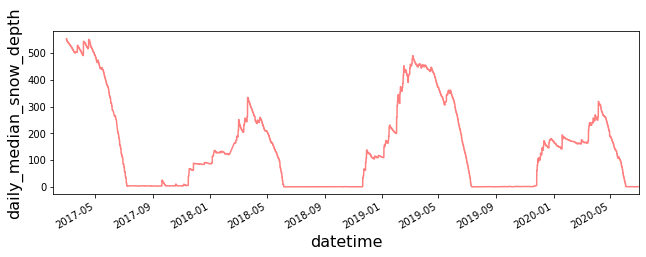

In [64]:
fig, ax = plt.subplots(figsize=(10.5,3))
cues_ds.daily_median_snow_depth.plot(color='red',label='Daily Median Snow Depth', ax=ax, alpha=0.5)
ax.set_xlim((pd.Timestamp('2017-02-01'),pd.Timestamp('2020-07-01')));

### 1M resample

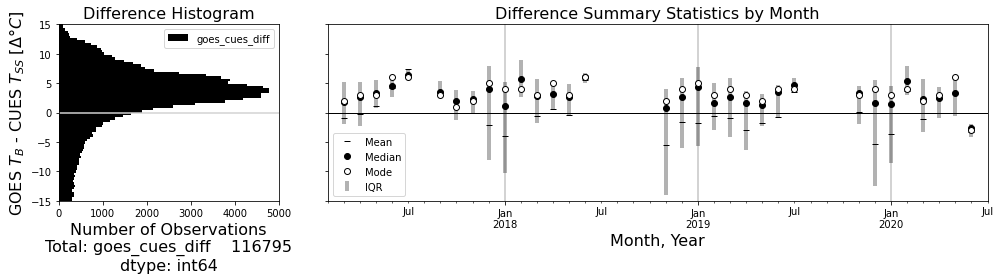

In [77]:
# Create DataArrayResample object
resampled_ds = cues_snow.goes_cues_diff.resample(datetime='1M')
# Run the resampled_stats function
resampled_df = rs.resampled_stats(resampled_ds, 0)

# Plot the results
fig, ax = rs.resampled_plot(cues_snow.goes_cues_diff.to_dataframe(), resampled_df, ymin=-15, ymax=15, xmin=0, xmax=5000, nbins=300)
# Add grid
ax[1].grid(which='major', axis='x', color='lightgrey', lw=2)
ax[1].set_xlim((pd.Timestamp('2017-02-01'),pd.Timestamp('2020-07-01')));
ax[1].set_title('Difference Summary Statistics by Month');
ax[1].set_xlabel('Month, Year');

### Month of Year groupby

Text(0.5, 0, 'Month of Year')

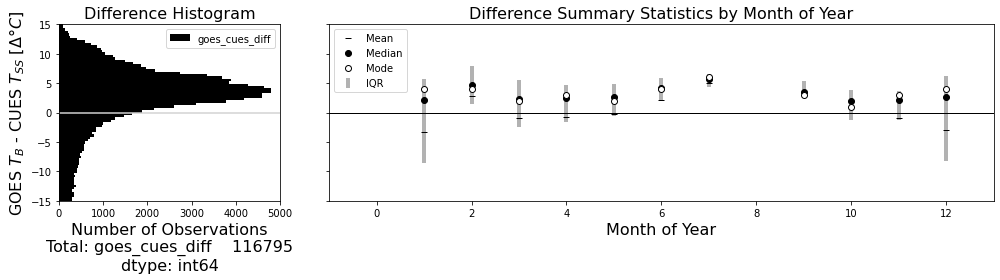

In [82]:
# Create DataArrayResample object
resampled_ds = cues_snow.goes_cues_diff.groupby('datetime.month')
# Run the resampled_stats function
resampled_df = rs.resampled_stats(resampled_ds, 0)

# Plot the results
fig, ax = rs.resampled_plot(cues_snow.goes_cues_diff.to_dataframe(), resampled_df, ymin=-15, ymax=15, xmin=0, xmax=5000, nbins=300)
ax[1].set_xlim((-1,13)) # fix axis limits
ax[1].set_title('Difference Summary Statistics by Month of Year')
ax[1].set_xlabel('Month of Year')

### Hour of Day, by Month-Year groupby

In [12]:
#df = cues_snow.to_dataframe()
#
#for year in df.index.year.unique():
#    mask = df.index.year==year
#    df_n = df.loc[mask]
#    
#    for month in df_n.index.month.unique():
#        mask = df_n.index.month==month
#        df_m = df_n.loc[mask]
#
#        # Create DataArrayResample object
#        resampled_ds = df_m.goes_cues_diff.groupby(df_m.index.hour)
#        # Run the resampled_stats function
#        resampled_df = rs.resampled_stats(resampled_ds, 0)
#        
#        # Plot the results
#        #fig, ax = resampled_plot(resampled_df, xmin=0, xmax=20, nbins=10)
#        
#        # Plot the results2
#        nbins = int(np.sqrt(df_m.goes_cues_diff.count()))+1
#        fig, ax = resampled_plot2(df_m.goes_cues_diff, resampled_df, ymin=-10, ymax=20, xmin=0, xmax=1000, nbins=nbins)
#        ax[1].set_title('Difference Summary Statistics by Hour of Day for {}-{}'.format(month, year))
#        ax[1].set_xlabel('Hour of Day')

### Hour of Day, by Month groupby

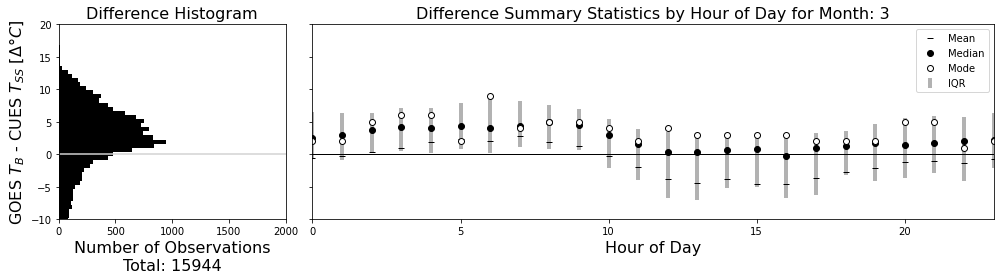

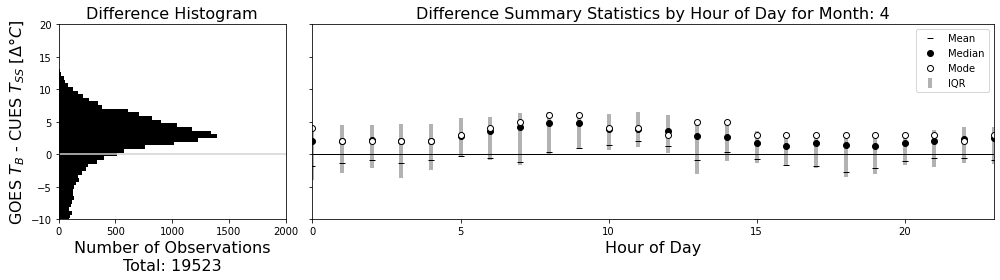

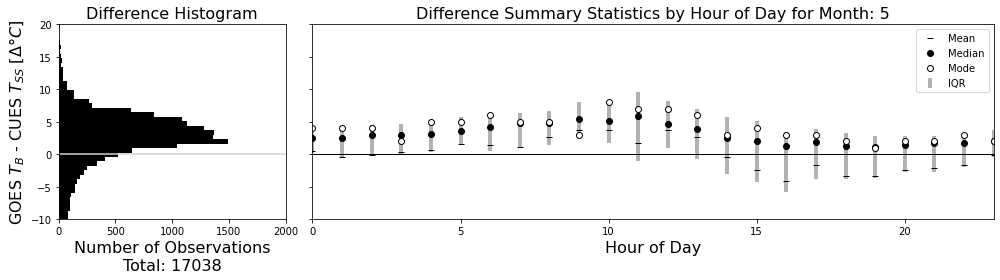

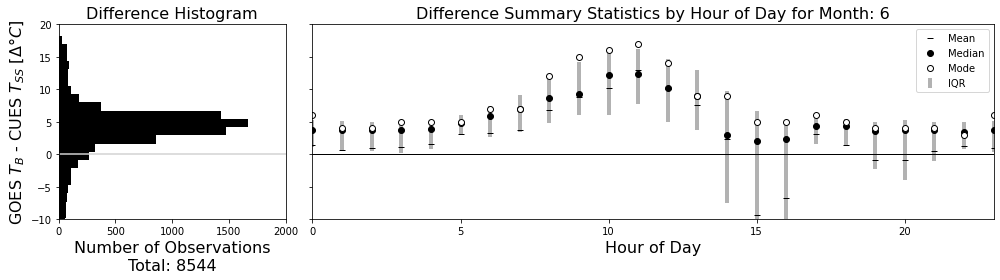

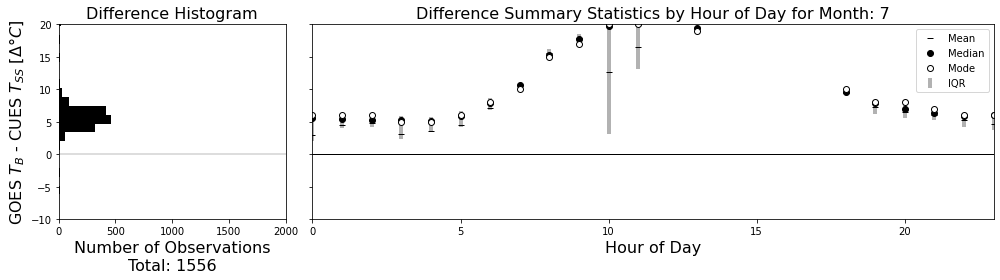

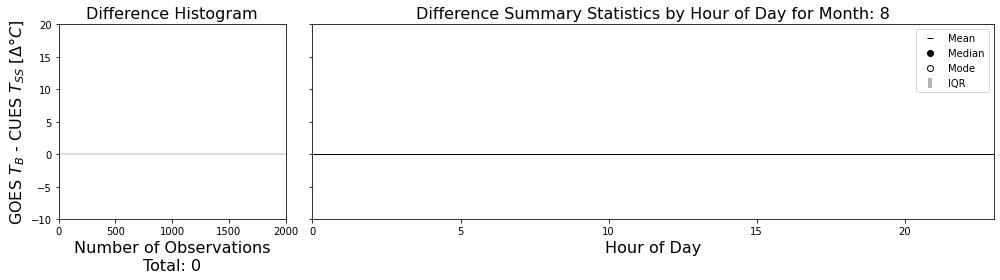

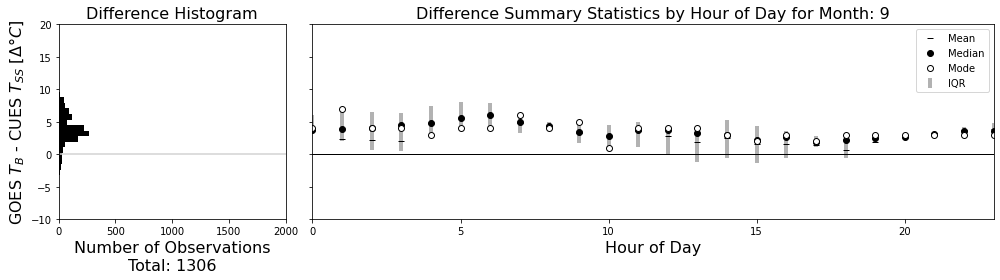

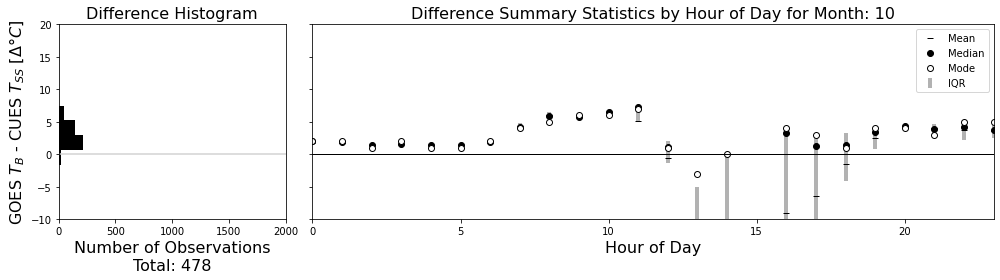

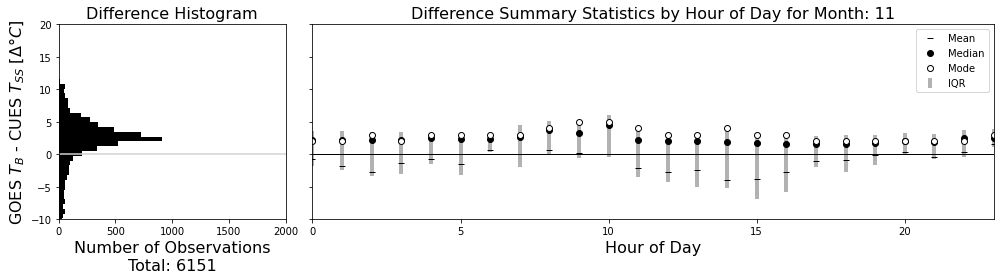

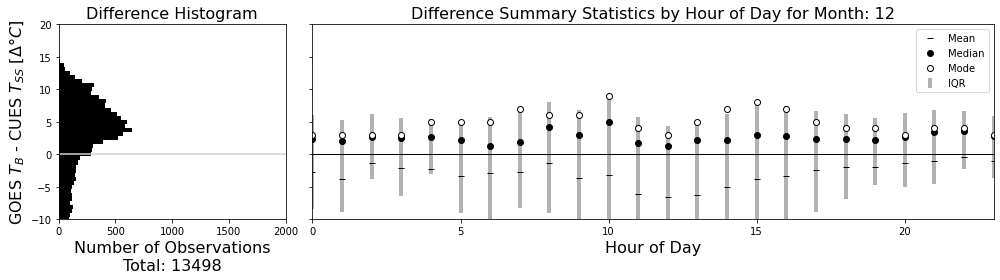

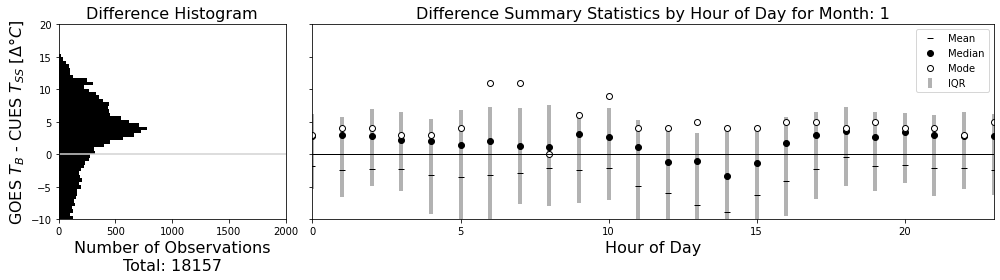

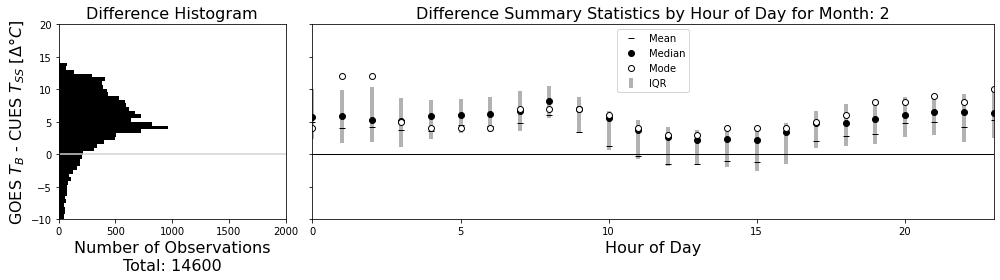

In [84]:
df = cues_snow.to_dataframe()

for month in df.index.month.unique():
    mask = df.index.month==month
    df_m = df.loc[mask]

    # Create DataArrayResample object
    resampled_ds = df_m.goes_cues_diff.groupby(df_m.index.hour)
    # Run the resampled_stats function
    resampled_df = rs.resampled_stats(resampled_ds, 0)
    
    # Plot the results
    nbins = int(np.sqrt(df_m.goes_cues_diff.count()))+1
    fig, ax = rs.resampled_plot(df_m.goes_cues_diff, resampled_df, ymin=-10, ymax=20, xmin=0, xmax=2000, nbins=nbins)
    ax[1].set_title('Difference Summary Statistics by Hour of Day for Month: {}'.format(month))
    ax[1].set_xlabel('Hour of Day')

### Hour of Day, by Season groupby

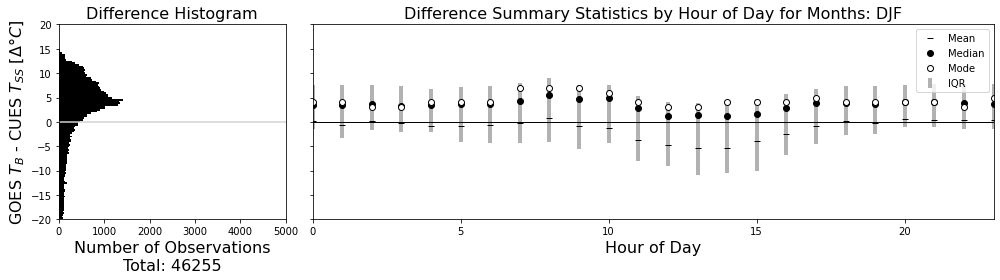

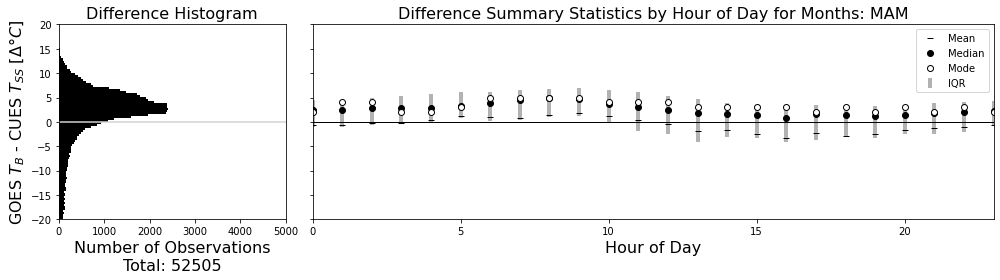

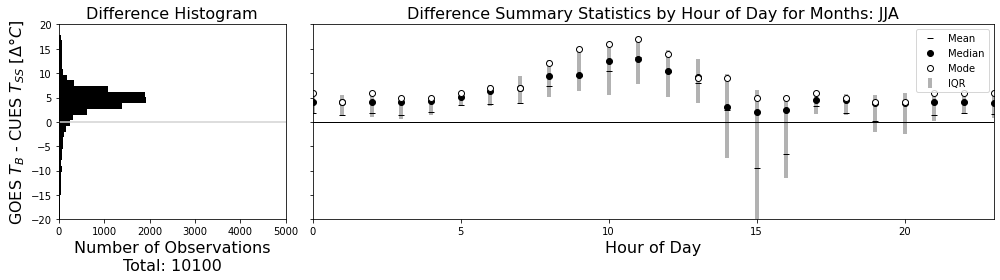

In [60]:
for season in ['DJF', 'MAM', 'JJA']:
    df_season = cues_snow.goes_cues_diff.where(cues_snow['datetime.season']==season).to_dataframe()

    # Create DataArrayResample object
    resampled_ds = df_season.goes_cues_diff.groupby(df_season.index.hour)
    # Run the resampled_stats function
    resampled_df = rs.resampled_stats(resampled_ds, 0)
    
    # Plot the results
    #fig, ax = resampled_plot(resampled_df, xmin=0, xmax=20, nbins=10)
    
    # Plot the results2
    nbins = int(np.sqrt(df_season.goes_cues_diff.count()))+1
    fig, ax = rs.resampled_plot(df_season.goes_cues_diff, resampled_df, ymin=-20, ymax=20, xmin=0, xmax=5000, nbins=nbins)
    ax[1].set_title('Difference Summary Statistics by Hour of Day for Months: {}'.format(season))
    ax[1].set_xlabel('Hour of Day')